# Comprehensive DMart Product Classification Analysis

This notebook provides an end-to-end analysis for classifying DMart products into categories. 
It integrates data preprocessing, feature engineering, and model training using multiple algorithms, including an Ensemble Voting Classifier.
Detailed evaluation metrics such as Confusion Matrices and ROC/AUC curves are provided for each model.

## Models Evaluated:
1.  **Logistic Regression** (Linear Model)
2.  **Random Forest** (Ensemble - Bagging)
3.  **XGBoost** (Ensemble - Boosting)
4.  **Voting Classifier** (Ensemble - Voting of the above 3 models)

In [5]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Data preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

# Machine Learning Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier

# Model evaluation metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report,
    roc_curve, roc_auc_score, auc
)
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


## 1. Load and Preprocess Data

In [6]:
# Load the dataset
try:
    df = pd.read_csv('DMart.csv')
    print("✅ Dataset loaded successfully!")
    print(f"Dataset Shape: {df.shape}")
except FileNotFoundError:
    print("❌ Error: 'DMart.csv' not found. Please ensure the file is in the same directory.")

# Handle Missing Values
df['Brand'].fillna('Unknown', inplace=True)
df.dropna(subset=['Price', 'DiscountedPrice', 'Category', 'Quantity'], inplace=True)

# Feature Engineering: Parse Quantity
def parse_quantity(q):
    if isinstance(q, str):
        q = q.lower()
        num = re.search(r'(\d+(\.\d+)?)', q)
        if num:
            val = float(num.group(1))
            if 'kg' in q or 'l' in q:
                val *= 1000
            return val
    return 0

df['Quantity_Value'] = df['Quantity'].apply(parse_quantity)

# Feature Engineering: Discount Percentage
df['DiscountPercentage'] = (df['Price'] - df['DiscountedPrice']) / df['Price']
df['DiscountPercentage'] = df['DiscountPercentage'].fillna(0)

# Filter out categories with less than 2 samples
min_samples = 2
category_counts = df['Category'].value_counts()
valid_categories = category_counts[category_counts >= min_samples].index
df = df[df['Category'].isin(valid_categories)]

print(f"Filtered Dataset Shape: {df.shape}")
print(f"Number of Categories: {df['Category'].nunique()}")

✅ Dataset loaded successfully!
Dataset Shape: (5189, 9)
Filtered Dataset Shape: (5179, 11)
Number of Categories: 24


## 2. Feature Encoding and Preparation

In [7]:
# Label Encoding
le_brand = LabelEncoder()
df['Brand_Encoded'] = le_brand.fit_transform(df['Brand'].astype(str))

le_category = LabelEncoder()
df['Category_Encoded'] = le_category.fit_transform(df['Category'])
class_names = le_category.classes_

# TF-IDF on Name (Text Feature)
print("Vectorizing Product Names...")
tfidf = TfidfVectorizer(max_features=2000, stop_words='english')
name_tfidf = tfidf.fit_transform(df['Name'].fillna(''))

# Numerical Features
X_numerical = df[['Brand_Encoded', 'Price', 'DiscountedPrice', 'Quantity_Value', 'DiscountPercentage']]

# Scaling Numerical Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numerical)

# Combine Numerical and Text Features
print("Combining Features...")
X = hstack([X_scaled, name_tfidf])
y = df['Category_Encoded']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"✅ Train-Test Split completed!")
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Vectorizing Product Names...
Combining Features...
✅ Train-Test Split completed!
Train shape: (4143, 2005), Test shape: (1036, 2005)


## 3. Model Training and Evaluation Loop

We will train and evaluate the following models separately:
1.  Logistic Regression
2.  Random Forest
3.  XGBoost
4.  Voting Classifier (Ensemble)

For each model, we will display:
*   Accuracy Score
*   Confusion Matrix
*   ROC Curve and AUC Score (Micro-average and per-class)


Training Logistic Regression...
Accuracy: 0.9044
                        precision    recall  f1-score   support

            Appliances       1.00      0.64      0.78        11
           Baby & Kids       0.00      0.00      0.00         1
             Backpacks       0.00      0.00      0.00         3
    Beauty & Cosmetics       1.00      0.33      0.50         9
             Butterfly       0.00      0.00      0.00         0
Clothing & Accessories       1.00      1.00      1.00        19
  Computer Accessories       0.00      0.00      0.00         0
         DMart Grocery       1.00      0.17      0.29         6
     Dairy & Beverages       0.88      0.78      0.83        86
   Fruits & Vegetables       1.00      0.50      0.67        16
                  Geep       0.00      0.00      0.00         1
               Grocery       0.95      0.93      0.94       168
        Home & Kitchen       0.89      0.95      0.92       176
         Joyo Plastics       0.00      0.00      0.00

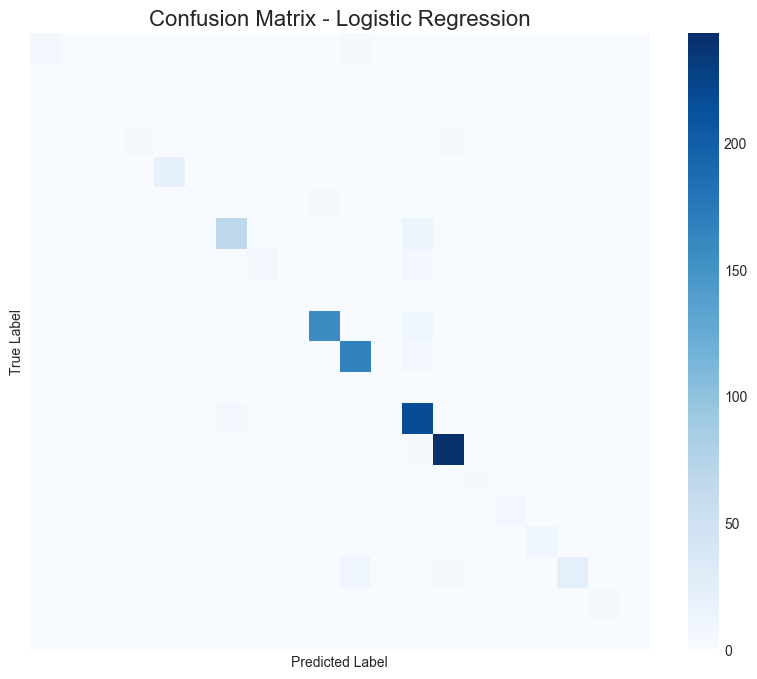

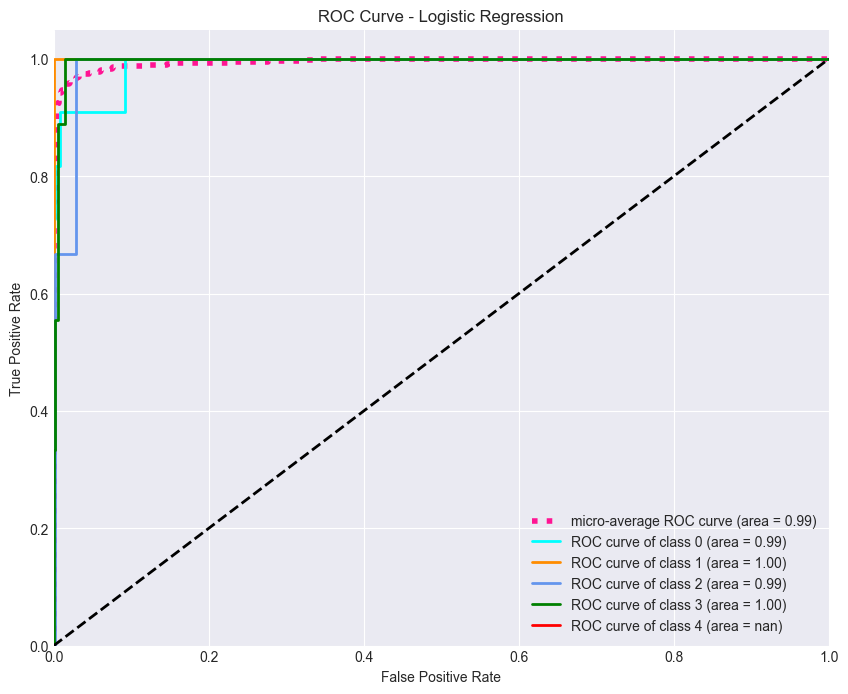


Training Random Forest...
Accuracy: 0.7944
                        precision    recall  f1-score   support

            Appliances       1.00      0.55      0.71        11
           Baby & Kids       0.00      0.00      0.00         1
             Backpacks       0.00      0.00      0.00         3
    Beauty & Cosmetics       1.00      0.22      0.36         9
             Butterfly       0.00      0.00      0.00         0
Clothing & Accessories       1.00      0.95      0.97        19
  Computer Accessories       0.00      0.00      0.00         0
         DMart Grocery       0.67      0.33      0.44         6
     Dairy & Beverages       0.96      0.58      0.72        86
   Fruits & Vegetables       1.00      0.44      0.61        16
                  Geep       0.00      0.00      0.00         1
               Grocery       0.96      0.77      0.85       168
        Home & Kitchen       0.78      0.78      0.78       176
         Joyo Plastics       0.00      0.00      0.00      

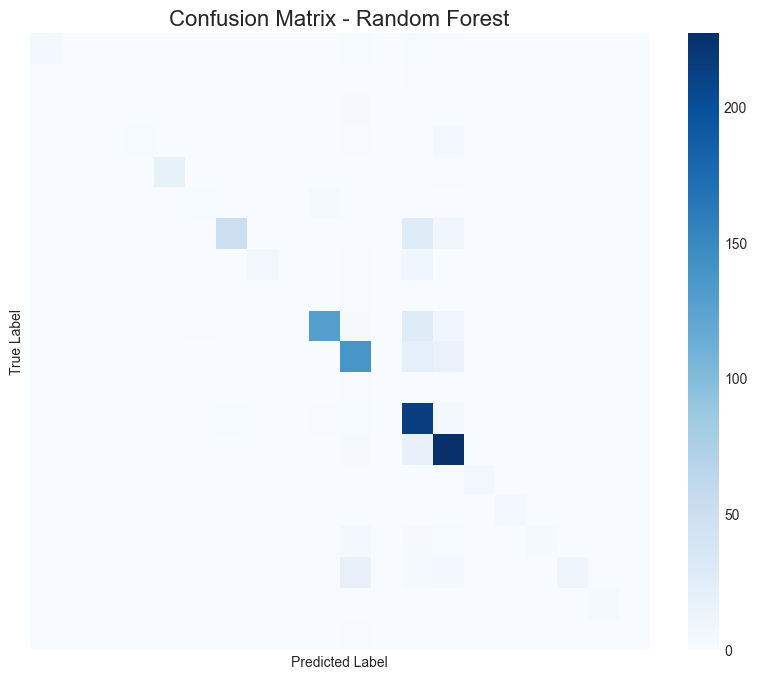

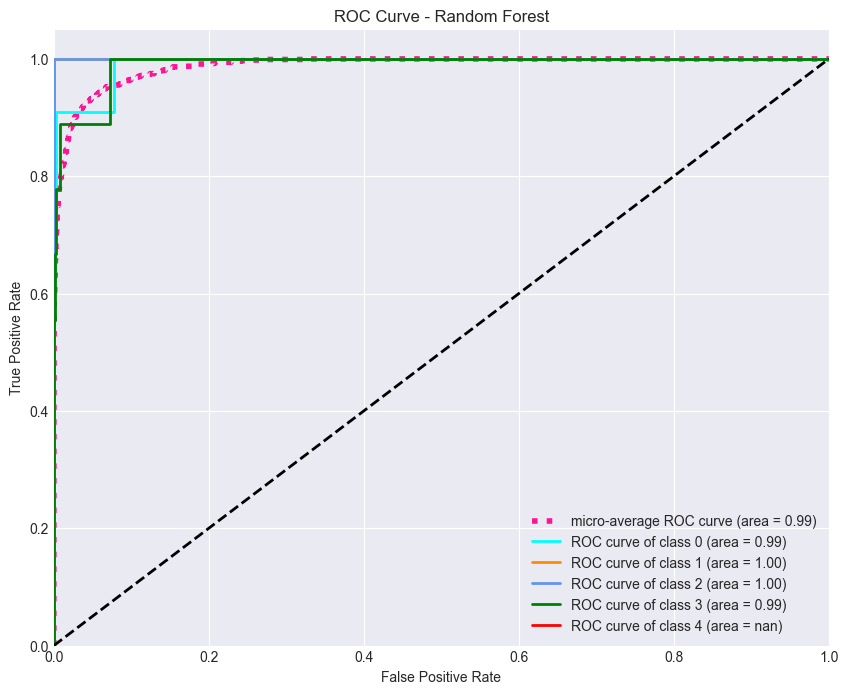


Training XGBoost...
Accuracy: 0.9025
                        precision    recall  f1-score   support

            Appliances       1.00      0.82      0.90        11
           Baby & Kids       1.00      1.00      1.00         1
             Backpacks       1.00      1.00      1.00         3
    Beauty & Cosmetics       0.67      0.44      0.53         9
             Butterfly       0.00      0.00      0.00         0
Clothing & Accessories       1.00      0.95      0.97        19
  Computer Accessories       0.00      0.00      0.00         0
         DMart Grocery       0.67      0.33      0.44         6
     Dairy & Beverages       0.94      0.86      0.90        86
   Fruits & Vegetables       1.00      0.69      0.81        16
                  Geep       0.00      0.00      0.00         1
               Grocery       0.92      0.92      0.92       168
        Home & Kitchen       0.88      0.92      0.90       176
         Joyo Plastics       0.00      0.00      0.00         0
 

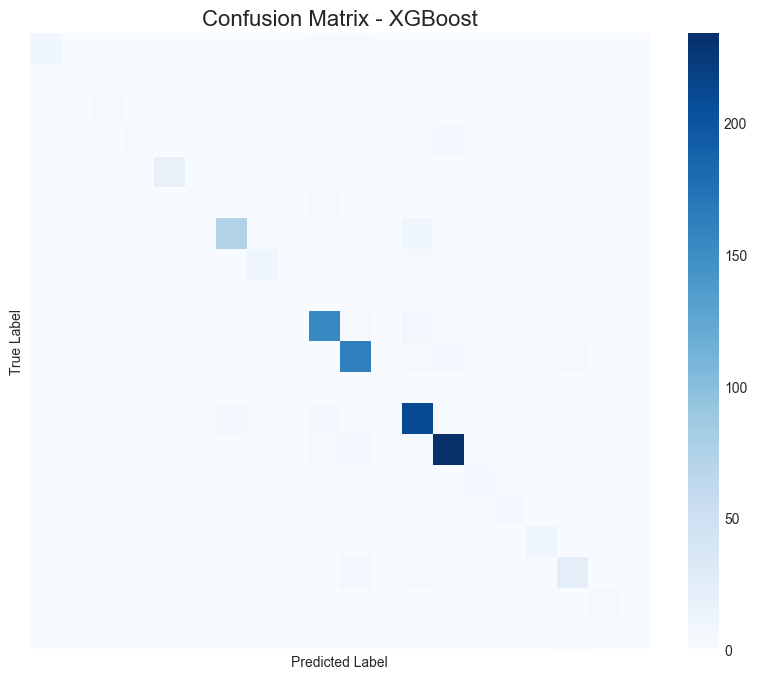

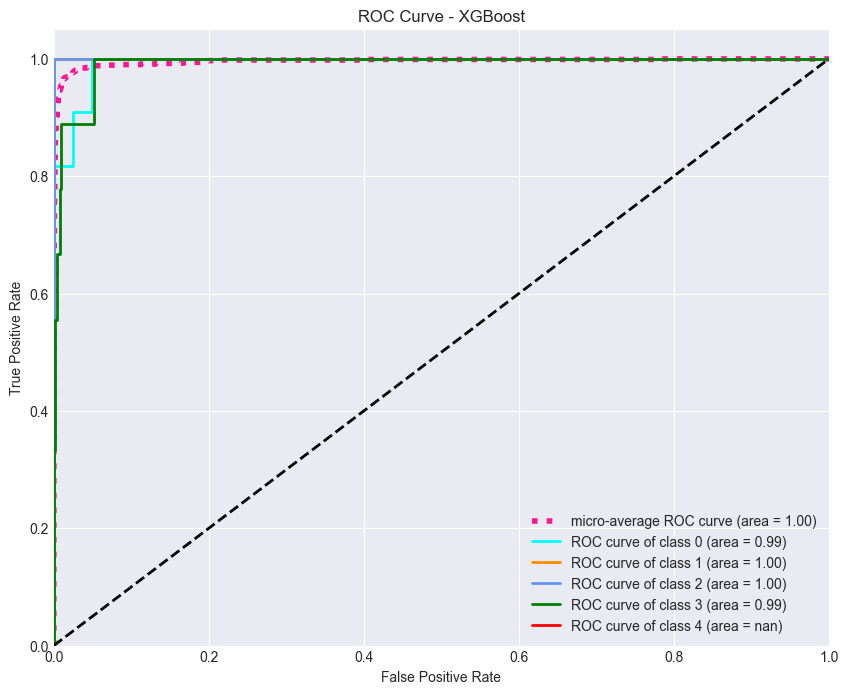


Training Ensemble Voting Classifier...
Accuracy: 0.9180
                        precision    recall  f1-score   support

            Appliances       1.00      0.64      0.78        11
           Baby & Kids       0.00      0.00      0.00         1
             Backpacks       1.00      1.00      1.00         3
    Beauty & Cosmetics       1.00      0.33      0.50         9
             Butterfly       0.00      0.00      0.00         0
Clothing & Accessories       1.00      1.00      1.00        19
  Computer Accessories       0.00      0.00      0.00         0
         DMart Grocery       0.67      0.33      0.44         6
     Dairy & Beverages       0.94      0.88      0.91        86
   Fruits & Vegetables       1.00      0.50      0.67        16
                  Geep       0.00      0.00      0.00         1
               Grocery       0.94      0.94      0.94       168
        Home & Kitchen       0.89      0.95      0.92       176
         Joyo Plastics       0.00      0.00   

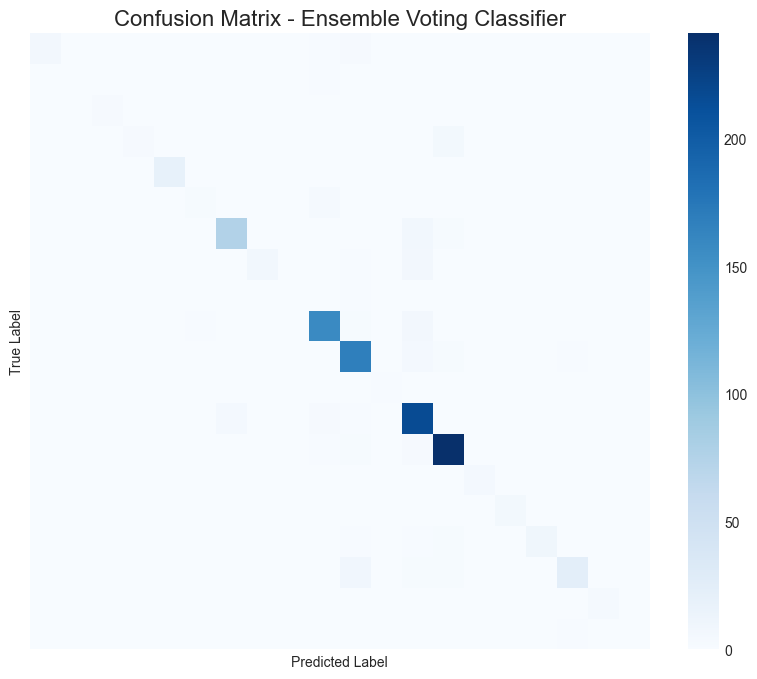

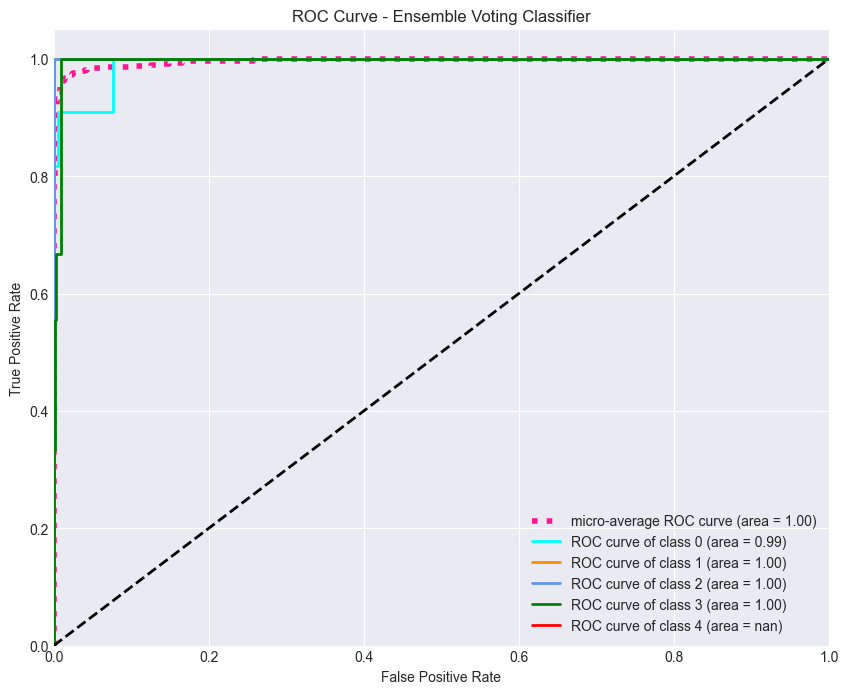


✅ All models trained and evaluated!


In [8]:
# Define Models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=300, max_depth=30, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', n_estimators=300, learning_rate=0.1, random_state=42)
}

# Add Voting Classifier
voting_clf = VotingClassifier(
    estimators=[
        ('lr', models["Logistic Regression"]),
        ('rf', models["Random Forest"]),
        ('xgb', models["XGBoost"])
    ],
    voting='soft'  # Soft voting for probability-based ROC/AUC
)
models["Ensemble Voting Classifier"] = voting_clf

# Function to plot Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', xticklabels=False, yticklabels=False)
    plt.title(f'Confusion Matrix - {title}', fontsize=16)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Function to plot ROC Curve
def plot_roc_curve(y_test, y_prob, title, n_classes):
    # Binarize the output
    y_test_bin = label_binarize(y_test, classes=range(n_classes))
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_prob.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Plot ROC curve
    plt.figure(figsize=(10, 8))
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    # Plot top 5 classes for clarity if many classes
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red'])
    for i, color in zip(range(min(n_classes, 5)), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {title}')
    plt.legend(loc="lower right")
    plt.show()

# Training and Evaluation Loop
results = {}

for name, model in models.items():
    print(f"\n{'='*60}")
    print(f"Training {name}...")
    print(f"{'='*60}")
    
    # Train
    model.fit(X_train, y_train)
    
    # Predict
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)
    
    # Metrics
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred, target_names=class_names, labels=range(len(class_names)), zero_division=0))
    
    # Visualizations
    plot_confusion_matrix(y_test, y_pred, name)
    plot_roc_curve(y_test, y_prob, name, len(class_names))

print("\n✅ All models trained and evaluated!")

## 4. Final Comparison


Model Comparison:
                        Model  Accuracy
3  Ensemble Voting Classifier  0.917954
0         Logistic Regression  0.904440
2                     XGBoost  0.902510
1               Random Forest  0.794402


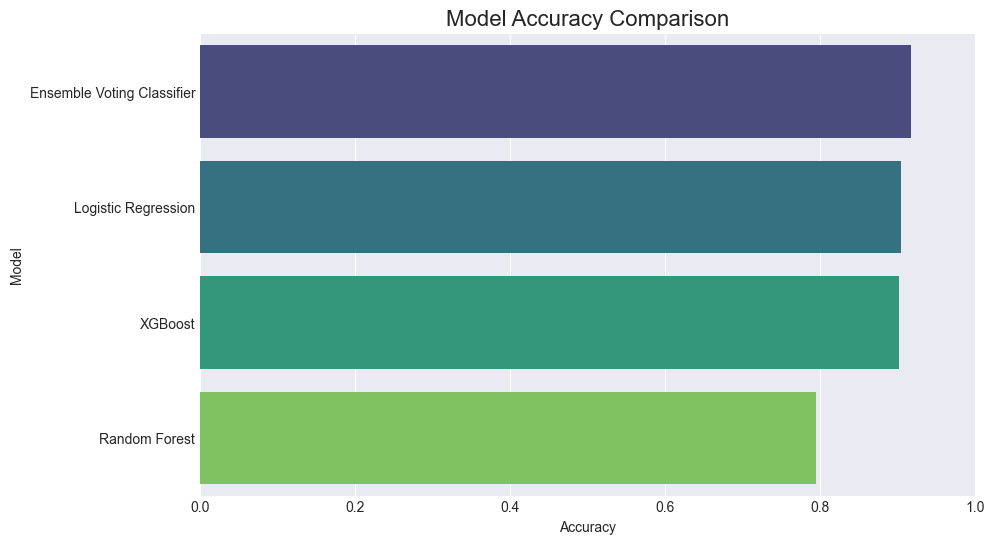

In [9]:
results_df = pd.DataFrame(list(results.items()), columns=['Model', 'Accuracy'])
results_df = results_df.sort_values(by='Accuracy', ascending=False)

print("\nModel Comparison:")
print(results_df)

plt.figure(figsize=(10, 6))
sns.barplot(x='Accuracy', y='Model', data=results_df, palette='viridis')
plt.title('Model Accuracy Comparison', fontsize=16)
plt.xlabel('Accuracy')
plt.xlim(0, 1.0)
plt.show()